In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [3]:
from datasets import load_dataset

ds = load_dataset("CyberNative/Code_Vulnerability_Security_DPO")
df = ds['train']


In [4]:
variant = goodfire.Variant("meta-llama/Meta-Llama-3.1-70B-Instruct")

In [10]:
# Convert rejected and chosen examples into dataframes
import random
import pandas as pd
random.seed(42)

# Create dataframe for rejected (vulnerable) examples
positive_examples = pd.DataFrame({
    'text': df['rejected'],
    'vulnerability': df['vulnerability'], 
    'question': df['question']
})

# Create dataframe for chosen (safe) examples  
negative_examples = pd.DataFrame({
    'text': df['chosen'],
    'vulnerability': df['vulnerability'],
    'question': df['question']
})

# Shuffle the dataframes
positive_examples = positive_examples.sample(frac=1, random_state=42)
negative_examples = negative_examples.sample(frac=1, random_state=42)

FEATURE_COMPUTE_SIZE = 20
CLASSIFIER_FULL_SET_SIZE = 150

In [102]:
vulnerable_features, safe_features = client.features.contrast(
    dataset_1=[
      [
          {"role": "user", "content": f"Is the following code vulnerable or safe? {text}"},
          {"role": "assistant", "content": "vulnerable"}
      ] for text in positive_examples[0:FEATURE_COMPUTE_SIZE]['text'].tolist()
    ],
    dataset_2=[
      [
          {"role": "user", "content": f"Is the following code vulnerable or safe? {text}"},
          {"role": "assistant", "content": "safe"}
      ] for text in negative_examples[0:FEATURE_COMPUTE_SIZE]['text'].tolist()
    ],
    dataset_1_feature_rerank_query="vulnerable code",
    dataset_2_feature_rerank_query="code",
    model=variant,
    top_k=100
)
features_to_look_at = vulnerable_features | safe_features
features_to_look_at

FeatureGroup([
   0: "Potentially harmful or malicious code requests that should be rejected",
   1: "Security vulnerabilities and exploitable weaknesses in systems",
   2: "Offensive security techniques and exploit descriptions",
   3: "Discussions of executing potentially malicious code or exploits",
   4: "Technical descriptions of security vulnerabilities and exploits",
   5: "Technical uses of injection across security vulnerabilities and legitimate applications",
   6: "Code will throw an exception or error",
   7: "Discussions of vulnerability and susceptibility to harm",
   8: "Security warning in technical documentation",
   ...
   199: "Syntactic equality comparison operators in programming languages"
])

In [104]:
[str(feature.uuid) for feature in features_to_look_at]


['e845a8d0-5fc8-4948-9c90-311a2937ac86',
 'a0ddefd1-ebf8-40f7-acf1-539597953827',
 '9aee40ff-8016-482c-9696-aba49f4842a7',
 '10eb4296-e867-4bdb-9ae1-38b51cac545e',
 '857150f3-7a09-45dc-9144-c415d937a973',
 'c70009bd-2305-4cbd-a09a-3fc3cdc2ee62',
 '91d01ece-d092-4345-84b8-2ead5247dc25',
 'b3aa8cd6-95c5-4bfc-a6ad-e8098f386034',
 'd49d0fd1-9d75-461c-8a1d-aa4d692393f6',
 '6ddc3fcc-b789-4f36-a251-77c117c20c37',
 '7dd36d05-c22c-4fd6-8de9-116d6d90e468',
 'be41c532-498f-456f-97d2-6359322d22bd',
 '550eca35-81f3-46dc-9137-e8b08aedb0a9',
 '38ce884c-6af6-4243-b9a6-5a95db045d1b',
 'decd3825-a5f1-4a57-add3-71ae5215b99b',
 '4f574bc5-7079-4038-b1ef-bbfa49d01668',
 'f30fe8f4-781b-4149-9be9-39031e14d931',
 'c9f449f7-0401-4580-9975-71a96aa21115',
 '80669299-e5bc-4934-89e0-d2423dbe8279',
 'de5e3c52-94e0-4d33-8824-d1e7a1248f47',
 '2519baeb-533a-4da2-8d6a-0e139557f7a7',
 '855734fe-a0d3-483c-9416-bc0f95e411b6',
 'f2ee27e1-cca6-446c-8d19-44b041f5dfa4',
 '480ce1f0-69b4-4c27-848b-3444c255f348',
 '3e39aa95-ee41-

In [86]:
features_to_look_at = client.features.list([
    'd3ca5198-d57a-4a04-b881-1944f3acee87',
    'f494a18d-df50-43d7-ae83-44c9125a263e', 
    'be4c7056-f932-4c08-8e72-57a55bf710f7',
    '9b5af293-c41f-4edd-8c8a-466d71974231',
    '3905b455-64fc-4c63-91f9-d2842f2bedfa',
    '9bd07add-b989-4051-980a-2a3cd341ee0c',
    'f2c7f5ce-ec37-477e-87dd-6312afc582b8',
    'edaf8bb2-c001-4bf8-8b1c-5dc0f785976c',
    '2734b2c0-ef4a-47ff-9836-9d359ff3e543',
    '4d3559cc-aeb2-4e28-80b8-ce9951b2a9bf',
    '77a70223-307d-43eb-b9f8-5123c969afa5'
])

In [13]:
from itertools import combinations


class FeatureMixer:
  def __init__(self, feature_group):
    self.feature_group = feature_group

  def grid(self, k_features_per_combo: int =2):
    """Perform a grid search over all possible combinations of features"""

    # Get all possible combinations of features
    return list(combinations(self.feature_group, k_features_per_combo))


In [82]:
import pandas as pd
import concurrent.futures as futures
import tqdm

CLASSIFIER_FULL_SET_SIZE = 150
def _get_feature_acts_for_sample_class(
    sample_class: pd.DataFrame,
    features_to_use_for_classification: goodfire.FeatureGroup,
    k=len(features_to_look_at),
):
    if k < len(features_to_use_for_classification):
        raise ValueError("k must be greater than the number of features to use for classification")

    def process_row(row):
        text = row['text']
        context = client.features.inspect(
            [
                {
                    "role": "user",
                    "content": f"Is the following Python code vulnerable or safe? {text}"
                }
            ],
            model=variant,
            features=features_to_use_for_classification,
        )
        return context.top(k=k)

    samples = []
    with futures.ThreadPoolExecutor(max_workers=4) as executor:
        future_to_row = {executor.submit(process_row, row): row for _, row in sample_class[0:CLASSIFIER_FULL_SET_SIZE].iterrows()}
        for future in tqdm.tqdm(futures.as_completed(future_to_row), total=len(future_to_row)):
            samples.append(future.result())

    return samples

print("Computing positive features...")
positive_class_features = _get_feature_acts_for_sample_class(positive_examples, features_to_look_at, k=100)

print("Computing negative features...")
negative_class_features = _get_feature_acts_for_sample_class(negative_examples, features_to_look_at, k=100)


Computing positive features...


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:56<00:00,  2.63it/s]


Computing negative features...


100%|██████████| 150/150 [01:03<00:00,  2.36it/s]


In [109]:
features_to_look_at

FeatureGroup([
   0: "Potentially harmful or malicious code requests that should be rejected",
   1: "Security vulnerabilities and exploitable weaknesses in systems",
   2: "Offensive security techniques and exploit descriptions",
   3: "Discussions of executing potentially malicious code or exploits",
   4: "Technical descriptions of security vulnerabilities and exploits",
   5: "Technical uses of injection across security vulnerabilities and legitimate applications",
   6: "Code will throw an exception or error",
   7: "Discussions of vulnerability and susceptibility to harm",
   8: "Security warning in technical documentation",
   ...
   199: "Syntactic equality comparison operators in programming languages"
])

In [83]:
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
import numpy as np
import tqdm


# Grid search may take a while, you can curate the feature list to speed this process up significantly
def train_tree(x, y, depth):
  train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.5, random_state=42)

  # Create a nice regularized tree
  model = tree.DecisionTreeClassifier(
      max_depth=depth,
      min_samples_leaf=len(train_x) // 20,
      random_state=42
  )

  model.fit(train_x, train_y)

  pred = model.predict(test_x)

  # Calculate the f1 score of the model
  accuracy = balanced_accuracy_score(test_y, pred)
  score = f1_score(test_y, pred)

  return model, pred, score, accuracy


def find_best_combo(features, k_features_per_combo = 2):
  combos = FeatureMixer(features).grid(k_features_per_combo=k_features_per_combo)
  best_combo = None
  best_model = None
  best_score = 0
  best_accuracy = 0

  MAX_WORKERS = 8

  futures_list = []

  with futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    for combo in combos:
      def _test_combo(combo):
        def _select_feature_acts(combo, row):
          output = []
          for index, feature in enumerate(combo):
            for feature_act in row:
              if feature_act.feature.uuid == feature.uuid:
                output.append(feature_act.activation)
                break

          return output

        x_negative = [_select_feature_acts(combo, row) for row in negative_class_features]
        x_positive = [_select_feature_acts(combo, row) for row in positive_class_features]

        y_negative = [-1] * len(x_negative)
        y_positive = [1] * len(x_positive)

        x = x_negative + x_positive
        y = y_negative + y_positive

        model, pred, score, accuracy = train_tree(x, y, depth=len(combo))

        return model, pred, score, accuracy, combo

      futures_list.append(executor.submit(_test_combo, combo))

    for future in tqdm.tqdm(futures_list):
      model, pred, score, accuracy, combo = future.result()

      if score > best_score:
        best_score = score
        best_combo = combo
        best_model = model
        best_accuracy = accuracy

  return best_combo, best_score, best_model, best_accuracy


best_combo_at_k = {}
for i in range(3):
  best_combo, best_score, best_model, best_accuracy = find_best_combo(features_to_look_at, k_features_per_combo = i + 1)
  print(i + 1, best_combo, best_score, best_accuracy, best_model)
  best_combo_at_k[i + 1] = (best_combo, best_score, best_model)


100%|██████████| 67/67 [00:00<00:00, 75.46it/s]


1 (Feature("Technical data structures and visualization objects in code"),) 0.7052631578947368 0.6383547008547008 DecisionTreeClassifier(max_depth=1, min_samples_leaf=7, random_state=42)


100%|██████████| 2211/2211 [00:44<00:00, 50.11it/s]


2 (Feature("Technical and compound word construction patterns"), Feature("Technical data structures and visualization objects in code")) 0.7292817679558011 0.6826923076923077 DecisionTreeClassifier(max_depth=2, min_samples_leaf=7, random_state=42)


100%|██████████| 47905/47905 [17:31<00:00, 45.55it/s]

3 (Feature("Inline hash symbol comments explaining specific code operations"), Feature("Sequential and nested program control flow patterns, especially combinations of loops and conditionals"), Feature("Technical and compound word construction patterns")) 0.7513812154696132 0.7094017094017093 DecisionTreeClassifier(max_depth=3, min_samples_leaf=7, random_state=42)


In [87]:
uuids = []
for i in range(3):
  for feature in best_combo_at_k[i + 1][0]:
    uuids.append(str(feature.uuid))

print(uuids)


['ccf6b9f5-cb96-4452-bb7a-b8215cecd55c', 'ee3d33af-7281-4450-8b3f-3389d8609dde', 'ccf6b9f5-cb96-4452-bb7a-b8215cecd55c', '8bd37716-c74c-494f-a555-1037f0eb0344', '0d477cc5-243e-4baa-85b1-829e9eb29a1d', 'ee3d33af-7281-4450-8b3f-3389d8609dde']


In [84]:
# Inspect features to understand their nuances better
best_individual_feature = best_combo_at_k[3][0][0]

print(best_individual_feature)

neighboring_features = client.features._experimental.neighbors(best_individual_feature, model=variant)
neighboring_features


Feature("Inline hash symbol comments explaining specific code operations")


FeatureGroup([
   0: "Programming language comment syntax for documentation",
   1: "Code comments in educational programming examples",
   2: "Python comment hashtags that introduce new code sections",
   3: "Python comment markers in tutorial code",
   4: "Code modification and variable manipulation operations",
   5: "Documentation and explanatory syntax in code",
   6: "Programming language comment syntax at start of code blocks",
   7: "Section-dividing comments in code that organize major steps",
   8: "Python code comments explaining functionality",
   9: "Code comment indicators for output statements"
])

In [92]:
# Function to visualize the decision tree
def visualize_tree(tree_model, features, class_names=['negative', 'positive']):
    import graphviz
    dot_data = tree.export_graphviz(
        tree_model, 
        out_file=None, 
        feature_names=[feature.label for feature in features],
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    return graph

DecisionTreeClassifier(max_depth=3, min_samples_leaf=7, random_state=42)
(Feature("Inline hash symbol comments explaining specific code operations"), Feature("Sequential and nested program control flow patterns, especially combinations of loops and conditionals"), Feature("Technical and compound word construction patterns"))
0.7513812154696132


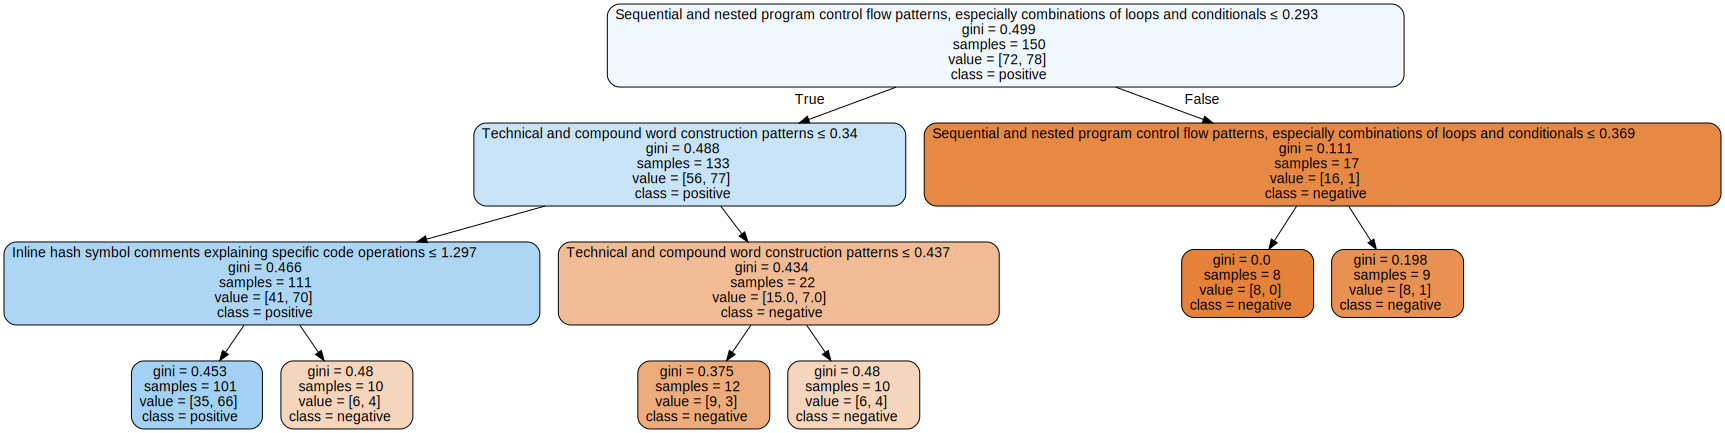

In [95]:
# Anyways let's look at the best overall tree
BEST_TREE_INDEX = 3
best_features = best_combo_at_k[BEST_TREE_INDEX][0]
best_score = best_combo_at_k[BEST_TREE_INDEX][1]
best_tree = best_combo_at_k[BEST_TREE_INDEX][2]

# Visualize the tree
print(best_tree)
print(best_features)
print(best_score)
visualize_tree(best_tree, best_features)

In [17]:
len(features_to_look_at)

67

In [119]:
import pandas as pd
import concurrent.futures as futures
import tqdm
import time
import random
import numpy as np
import os

CLASSIFIER_FULL_SET_SIZE = 3000
NUM_WORKERS = 8

def process_row(args):
    row, features_to_use_for_classification, k, variant = args
    text = row['text']
    
    max_retries = 5
    for attempt in range(max_retries):
        try:
            context = client.features.inspect(
                [
                    {
                        "role": "user",
                        "content": f"Is the following code vulnerable or safe? {text}"
                    }
                ],
                model=variant,
                features=features_to_use_for_classification,
            )
            features = context.top(k=k)
            vector = np.array([next((f.activation for f in features if f.feature.uuid == feature.uuid), 0) for feature in features_to_use_for_classification])
            return vector
        except Exception as e:
            if attempt == max_retries - 1:
                raise
            sleep_time = (2 ** attempt) + random.uniform(0, 1)
            time.sleep(sleep_time)

def lr_get_features_for_class(
    sample_class: pd.DataFrame,
    features_to_use_for_classification: goodfire.FeatureGroup,
    k=len(features_to_look_at),
    resume_from=None
):
    if k < len(features_to_use_for_classification):
        raise ValueError("k must be greater than the number of features to use for classification")

    matrix = np.zeros((sample_class.shape[0], len(features_to_use_for_classification)))
    
    start_index = 0
    if resume_from is not None and os.path.exists(resume_from):
        matrix = np.load(resume_from)
        if matrix.shape[0] < sample_class.shape[0]:
            expanded_matrix = np.zeros((sample_class.shape[0], len(features_to_use_for_classification)))
            expanded_matrix[:matrix.shape[0]] = matrix
            matrix = expanded_matrix
        start_index = np.count_nonzero(np.any(matrix != 0, axis=1))
        print(f"Resuming from index {start_index}")
    
    with futures.ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        args_list = [(row, features_to_use_for_classification, k, variant) 
                     for _, row in sample_class[start_index:].iterrows()]
        
        for i, result in enumerate(tqdm.tqdm(executor.map(process_row, args_list), 
                                             total=sample_class.shape[0]-start_index, 
                                             desc="Processing rows",
                                             initial=start_index)):
            matrix[start_index + i] = result
            if (start_index + i + 1) % 50 == 0:
                np.save(resume_from, matrix)
                print(f"Saved progress at iteration {start_index + i + 1}")
    
    return matrix

print("Computing positive features...")
lr_positive_class_features = lr_get_features_for_class(positive_examples[:2000], features_to_look_at, resume_from='lr_positive_class_features.npy')
np.save('lr_positive_class_features.npy', lr_positive_class_features)

print("Computing negative features...")
lr_negative_class_features = lr_get_features_for_class(negative_examples[:2000], features_to_look_at, resume_from='lr_negative_class_features.npy')
np.save('lr_negative_class_features.npy', lr_negative_class_features)

print("Features saved to lr_positive_class_features.npy and lr_negative_class_features.npy")

# To reload the features later, you can use:
# lr_positive_class_features = np.load('lr_positive_class_features.npy')
# lr_negative_class_features = np.load('lr_negative_class_features.npy')


Computing positive features...
Resuming from index 200


Processing rows:  14%|█▍        | 250/1800 [00:16<06:08,  4.20it/s]

Saved progress at iteration 250


Processing rows:  16%|█▋        | 297/1800 [00:29<11:42,  2.14it/s]

Saved progress at iteration 300


Processing rows:  19%|█▉        | 348/1800 [00:45<07:56,  3.04it/s]

Saved progress at iteration 350


Processing rows:  22%|██▏       | 399/1800 [01:03<11:17,  2.07it/s]

Saved progress at iteration 400


Processing rows:  25%|██▌       | 450/1800 [01:17<04:53,  4.60it/s]

Saved progress at iteration 450


Processing rows:  28%|██▊       | 498/1800 [01:33<07:17,  2.98it/s]

Saved progress at iteration 500


Processing rows:  31%|███       | 550/1800 [01:49<04:09,  5.02it/s]

Saved progress at iteration 550


Processing rows:  33%|███▎      | 600/1800 [02:07<09:00,  2.22it/s]

Saved progress at iteration 600


Processing rows:  36%|███▌      | 649/1800 [02:23<05:49,  3.29it/s]

Saved progress at iteration 650


Processing rows:  39%|███▉      | 700/1800 [02:39<05:44,  3.20it/s]

Saved progress at iteration 700


Processing rows:  42%|████▏     | 747/1800 [02:55<05:55,  2.96it/s]

Saved progress at iteration 750


Processing rows:  44%|████▍     | 800/1800 [03:10<05:51,  2.84it/s]

Saved progress at iteration 800


Processing rows:  47%|████▋     | 850/1800 [03:23<04:24,  3.59it/s]

Saved progress at iteration 850


Processing rows:  50%|█████     | 902/1800 [03:36<02:39,  5.63it/s]

Saved progress at iteration 900


Processing rows:  53%|█████▎    | 950/1800 [03:49<03:08,  4.52it/s]

Saved progress at iteration 950


Processing rows:  56%|█████▌    | 1001/1800 [04:02<02:45,  4.83it/s]

Saved progress at iteration 1000


Processing rows:  58%|█████▊    | 1049/1800 [04:15<03:28,  3.61it/s]

Saved progress at iteration 1050


Processing rows:  61%|██████    | 1098/1800 [04:27<03:16,  3.57it/s]

Saved progress at iteration 1100


Processing rows:  64%|██████▍   | 1150/1800 [04:41<03:16,  3.31it/s]

Saved progress at iteration 1150


Processing rows:  67%|██████▋   | 1204/1800 [04:56<01:58,  5.03it/s]

Saved progress at iteration 1200


Processing rows:  69%|██████▉   | 1250/1800 [05:10<03:06,  2.95it/s]

Saved progress at iteration 1250


Processing rows:  72%|███████▏  | 1299/1800 [05:25<03:32,  2.36it/s]

Saved progress at iteration 1300


Processing rows:  75%|███████▍  | 1349/1800 [05:37<01:55,  3.89it/s]

Saved progress at iteration 1350


Processing rows:  77%|███████▋  | 1391/1800 [06:07<09:55,  1.46s/it]

Saved progress at iteration 1400


Processing rows:  80%|███████▉  | 1437/1800 [06:08<01:38,  3.67it/s]

Saved progress at iteration 1450


Processing rows:  83%|████████▎ | 1499/1800 [06:21<01:32,  3.24it/s]

Saved progress at iteration 1500


Processing rows:  86%|████████▌ | 1546/1800 [06:36<03:54,  1.08it/s]

Saved progress at iteration 1550


Processing rows:  89%|████████▊ | 1596/1800 [06:50<01:02,  3.26it/s]

Saved progress at iteration 1600


Processing rows:  92%|█████████▏| 1654/1800 [07:06<00:32,  4.50it/s]

Saved progress at iteration 1650


Processing rows:  94%|█████████▍| 1700/1800 [07:20<00:27,  3.60it/s]

Saved progress at iteration 1700


Processing rows:  97%|█████████▋| 1744/1800 [07:33<00:19,  2.87it/s]

Saved progress at iteration 1750


Processing rows: 1801it [07:49,  3.83it/s]                          

Saved progress at iteration 1800


Processing rows: 1857it [08:04,  4.89it/s]

Saved progress at iteration 1850


Processing rows: 1898it [08:15,  3.76it/s]

Saved progress at iteration 1900


Processing rows: 1950it [08:32,  2.79it/s]

Saved progress at iteration 1950


Processing rows: 2000it [08:42,  3.44it/s]


Saved progress at iteration 2000
Computing negative features...


Processing rows:   2%|▏         | 49/2000 [00:14<10:23,  3.13it/s] 

Saved progress at iteration 50


Processing rows:   5%|▍         | 99/2000 [00:27<07:53,  4.01it/s]

Saved progress at iteration 100


Processing rows:   7%|▋         | 148/2000 [00:40<09:11,  3.36it/s]

Saved progress at iteration 150


Processing rows:  10%|█         | 200/2000 [00:53<05:42,  5.26it/s]

Saved progress at iteration 200


Processing rows:  12%|█▏        | 249/2000 [01:12<53:26,  1.83s/it]

Saved progress at iteration 250


Processing rows:  15%|█▌        | 300/2000 [01:22<09:01,  3.14it/s]

Saved progress at iteration 300


Processing rows:  18%|█▊        | 350/2000 [01:34<05:48,  4.73it/s]

Saved progress at iteration 350


Processing rows:  20%|██        | 400/2000 [01:48<06:27,  4.13it/s]

Saved progress at iteration 400


Processing rows:  22%|██▏       | 447/2000 [02:06<15:07,  1.71it/s]

Saved progress at iteration 450


Processing rows:  25%|██▌       | 500/2000 [02:20<06:18,  3.97it/s]

Saved progress at iteration 500


Processing rows:  27%|██▋       | 549/2000 [02:39<13:37,  1.77it/s]

Saved progress at iteration 550


Processing rows:  30%|███       | 600/2000 [02:53<05:05,  4.58it/s]

Saved progress at iteration 600


Processing rows:  32%|███▏      | 646/2000 [03:11<09:56,  2.27it/s]

Saved progress at iteration 650


Processing rows:  35%|███▌      | 700/2000 [03:25<05:13,  4.14it/s]

Saved progress at iteration 700


Processing rows:  37%|███▋      | 748/2000 [03:40<08:38,  2.42it/s]

Saved progress at iteration 750


Processing rows:  40%|███▉      | 799/2000 [03:56<09:58,  2.01it/s]

Saved progress at iteration 800


Processing rows:  42%|████▏     | 841/2000 [04:11<11:32,  1.67it/s]

Saved progress at iteration 850


Processing rows:  45%|████▍     | 899/2000 [04:40<10:23,  1.77it/s]

Saved progress at iteration 900


Processing rows:  47%|████▋     | 948/2000 [04:55<04:47,  3.66it/s]

Saved progress at iteration 950


Processing rows:  50%|█████     | 1000/2000 [05:10<05:11,  3.21it/s]

Saved progress at iteration 1000


Processing rows:  52%|█████▏    | 1048/2000 [05:25<05:31,  2.87it/s]

Saved progress at iteration 1050


Processing rows:  55%|█████▍    | 1093/2000 [05:39<06:53,  2.19it/s]

Saved progress at iteration 1100


Processing rows:  57%|█████▊    | 1150/2000 [05:57<05:56,  2.39it/s]

Saved progress at iteration 1150


Processing rows:  60%|██████    | 1200/2000 [06:11<04:58,  2.68it/s]

Saved progress at iteration 1200


Processing rows:  62%|██████▏   | 1248/2000 [06:35<27:32,  2.20s/it]

Saved progress at iteration 1250


Processing rows:  65%|██████▌   | 1300/2000 [06:49<03:28,  3.35it/s]

Saved progress at iteration 1300


Processing rows:  67%|██████▋   | 1349/2000 [07:09<07:43,  1.41it/s]

Saved progress at iteration 1350


Processing rows:  70%|███████   | 1400/2000 [07:22<02:39,  3.77it/s]

Saved progress at iteration 1400


Processing rows:  73%|███████▎  | 1453/2000 [07:38<02:36,  3.50it/s]

Saved progress at iteration 1450


Processing rows:  75%|███████▌  | 1500/2000 [07:52<02:44,  3.04it/s]

Saved progress at iteration 1500


Processing rows:  77%|███████▋  | 1549/2000 [08:08<02:26,  3.08it/s]

Saved progress at iteration 1550


Processing rows:  80%|████████  | 1600/2000 [08:24<02:04,  3.21it/s]

Saved progress at iteration 1600


Processing rows:  82%|████████▏ | 1649/2000 [08:40<02:34,  2.27it/s]

Saved progress at iteration 1650


Processing rows:  85%|████████▍ | 1699/2000 [08:55<01:32,  3.24it/s]

Saved progress at iteration 1700


Processing rows:  87%|████████▋ | 1747/2000 [09:12<02:05,  2.02it/s]

Saved progress at iteration 1750


Processing rows:  90%|████████▉ | 1799/2000 [09:27<01:17,  2.60it/s]

Saved progress at iteration 1800


Processing rows:  92%|█████████▎| 1850/2000 [09:43<01:00,  2.47it/s]

Saved progress at iteration 1850


Processing rows:  95%|█████████▍| 1896/2000 [10:00<00:47,  2.20it/s]

Saved progress at iteration 1900


Processing rows:  98%|█████████▊| 1950/2000 [10:13<00:13,  3.83it/s]

Saved progress at iteration 1950


Processing rows: 100%|██████████| 2000/2000 [10:26<00:00,  3.19it/s]

Saved progress at iteration 2000
Features saved to lr_positive_class_features.npy and lr_negative_class_features.npy


In [72]:
lr_positive_class_features = lr_positive_class_features[:2000]

In [124]:
lr_positive_class_features.shape


(2000, 200)

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GridSearchCV


# Data
# Combine positive and negative examples for features and labels
X = np.vstack([lr_positive_class_features, lr_negative_class_features])
y = np.hstack([np.ones(lr_positive_class_features.shape[0]), 
               np.zeros(lr_negative_class_features.shape[0])])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)


# Initialize scaler and model
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the features
X_train_scaled = scaler.fit_transform(lr_positive_class_features)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Algorithm to use
    'class_weight': [None, 'balanced'],  # Weight for classes
    'max_iter': [1000]  # Keep high enough to ensure convergence
}

base_model = LogisticRegression(max_iter=1000)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Can also use 'accuracy', 'precision', 'recall', 'roc_auc'
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use best model for predictions
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test_scaled)
y_pred_proba_test = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate test metrics
print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
print(f"F1: {f1_score(y_test, y_pred_test):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")

# Print feature indexes with the highest weights and their labels
feature_weights = model.coef_[0]
top_feature_indices = np.argsort(np.abs(feature_weights))[::-1][:10]  # Get top 10 feature indices
print("\nTop 10 Features with Highest Weights:")

print(top_feature_indices)
for idx in top_feature_indices:
    print(f"Feature {idx}, {str(features_to_look_at[int(idx)].uuid)}: {features_to_look_at[int(idx)]} (Weight: {feature_weights[idx]:.4f})")

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/ubuntu/goodfire-hackathon/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/goodfire-hackathon/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/goodfire-hackathon/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/goodfire-hackathon/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/goodfire-hackathon/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


Best parameters: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.4911964264549066

Test Metrics:
Accuracy: 0.4020
Precision: 0.4272
Recall: 0.5197
F1: 0.4689
AUC-ROC: 0.3409

Top 10 Features with Highest Weights:
[119 130 163  26 112 104  29  13  68 174]
Feature 119, a56cc632-1f98-4468-a1cc-47b7edab8e53: Feature("Closing parentheses in programming code contexts") (Weight: -1.1335)
Feature 130, 89747292-8acc-4940-a59d-16be3fb1d665: Feature("Opening parenthesis in programming control flow statements") (Weight: 1.0888)
Feature 163, faeaf4a9-8e9f-4e12-9677-c80e753cbf06: Feature("Mathematical increment and decrement operators in programming code") (Weight: -1.0730)
Feature 26, 0c4b4ffa-29ca-4eab-94ca-a66871dff2e2: Feature("C/C++ code syntax and structure patterns") (Weight: -1.0628)
Feature 112, 3d2b2063-05cc-4a32-9ac3-e97a467fa948: Feature("Code block closures and error handling syntax") (Weight: 1.0473)
Feature 

In [127]:
uuids = [str(features_to_look_at[int(idx)].uuid) for idx in top_feature_indices]
print(uuids)


['a56cc632-1f98-4468-a1cc-47b7edab8e53', '89747292-8acc-4940-a59d-16be3fb1d665', 'faeaf4a9-8e9f-4e12-9677-c80e753cbf06', '0c4b4ffa-29ca-4eab-94ca-a66871dff2e2', '3d2b2063-05cc-4a32-9ac3-e97a467fa948', 'b795ebf8-5776-438d-986d-f8476b16eedb', '235cb931-8b2c-483f-88e4-d659109ac41b', '38ce884c-6af6-4243-b9a6-5a95db045d1b', '4ecfe1ff-948b-4f6b-83ba-47f911fbb966', 'c0aa32db-d432-4f61-956e-34ecd245e272']


In [50]:
print(features_to_look_at[2])

Feature("Template placeholders and numbered sequences in generated content")
